@author: Pavlo Mospan

### All needed impots

In [ ]:
import os
import numpy as np
from datetime import datetime, date, timedelta

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

!pip install yfinance
import yfinance as yf

### Downloading Ethereum dataframe with yahoo finance API and then plotting the dataframe

**reset_index** method is used only to make normal numerical indexes, instead of *Date* beeig an index


In [2]:
df = yf.download('ETH-USD', start='2015-08-07')
df = df.reset_index()
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100
...,...,...,...,...,...,...,...
1999,2021-01-30,1382.231934,1402.399780,1328.529053,1376.115479,1376.115479,30616574234
2000,2021-01-31,1376.823608,1378.916016,1288.501587,1314.986206,1314.986206,25198853581
2001,2021-02-01,1314.855225,1373.845825,1274.357788,1369.040527,1369.040527,29210670920
2002,2021-02-02,1369.505127,1542.990967,1362.771240,1515.193726,1515.193726,45437142801


Text(0, 0.5, 'Close Price (USD)')

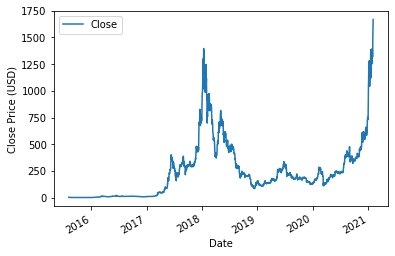

In [3]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

### Normalization

Since the scaler expects the data to be shaped as (x, y), I'm adding a dummy dimension using reshape before applying it. 

**reshape** method transforms array of *Closed* values from shape (2001, 1) into (2001, 1)

In [4]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

scaled_close.shape, np.isnan(scaled_close).any()

((2004, 1), False)

### Preprocessing

 LSTMs expect the data to be in 3 dimensions. We need to split the data into sequences of some preset length. The shape we want to obtain is: **[batch_size, sequence_length, n_features]**

 The process of building sequences works by creating a sequence of a specified length at position 0. Then it's shifted one position to the right (e.g. 1) and creates another sequence. The process is repeated until all possible positions are used.

 Here, *SEQ_LEN* parameter is set to 20, which means, that 20 days are predicting the next one

In [5]:
SEQ_LEN = 20
whole_data = np.empty([1, 20, 1])
whole_targets = np.empty([1, 1])

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len + 1):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    global whole_data, whole_targets
    whole_data = to_sequences(data_raw, seq_len)
    whole_targets = whole_data[:, -1, :]
    print('whole_data: ', whole_data.shape)
    print('whole_targets: ', whole_targets.shape)

    num_train = int(train_split * whole_data.shape[0])

    X_train = whole_data[:num_train, :, :]
    y_train = whole_data[:num_train, -1, :]

    X_test = whole_data[num_train:, :, :]
    y_test = whole_data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

X_train.shape, X_test.shape

whole_data:  (1985, 20, 1)
whole_targets:  (1985, 1)


((1885, 20, 1), (100, 20, 1))

#### Simply checking arrays if everything's alright

In [6]:
# Last 20 scaled values of the DataFrame
scaled_close[-20:], scaled_close.shape

(array([[0.70257071],
        [0.73957833],
        [0.73755989],
        [0.75381804],
        [0.82580028],
        [0.82878603],
        [0.67242405],
        [0.74136241],
        [0.73805072],
        [0.83438508],
        [0.79408377],
        [0.81366225],
        [0.75136354],
        [0.77830202],
        [0.82893524],
        [0.8250923 ],
        [0.78842878],
        [0.82084895],
        [0.90850729],
        [1.        ]]), (2004, 1))

In [7]:
print('The last 2 sequences from whole sequenced data and it\'s shape: \n {} | {} \n Last 5 values to predict (simple values from DF) : \n \
    {}'.format(whole_data[-2:], whole_data.shape, whole_targets[-5:]))

The last 2 sequences from whole sequenced data and it's shape: 
 [[[0.73053104]
  [0.70257071]
  [0.73957833]
  [0.73755989]
  [0.75381804]
  [0.82580028]
  [0.82878603]
  [0.67242405]
  [0.74136241]
  [0.73805072]
  [0.83438508]
  [0.79408377]
  [0.81366225]
  [0.75136354]
  [0.77830202]
  [0.82893524]
  [0.8250923 ]
  [0.78842878]
  [0.82084895]
  [0.90850729]]

 [[0.70257071]
  [0.73957833]
  [0.73755989]
  [0.75381804]
  [0.82580028]
  [0.82878603]
  [0.67242405]
  [0.74136241]
  [0.73805072]
  [0.83438508]
  [0.79408377]
  [0.81366225]
  [0.75136354]
  [0.77830202]
  [0.82893524]
  [0.8250923 ]
  [0.78842878]
  [0.82084895]
  [0.90850729]
  [1.        ]]] | (1985, 20, 1) 
 Last 5 values to predict (simple values from DF) : 
     [[0.8250923 ]
 [0.78842878]
 [0.82084895]
 [0.90850729]
 [1.        ]]


In [8]:
X_test[-1], X_test.shape

(array([[0.70257071],
        [0.73957833],
        [0.73755989],
        [0.75381804],
        [0.82580028],
        [0.82878603],
        [0.67242405],
        [0.74136241],
        [0.73805072],
        [0.83438508],
        [0.79408377],
        [0.81366225],
        [0.75136354],
        [0.77830202],
        [0.82893524],
        [0.8250923 ],
        [0.78842878],
        [0.82084895],
        [0.90850729],
        [1.        ]]), (100, 20, 1))

In [9]:
y_test[-5:], y_test.shape

(array([[0.8250923 ],
        [0.78842878],
        [0.82084895],
        [0.90850729],
        [1.        ]]), (100, 1))

### Model

Bidirectional RNNs allows us to train on the sequence data in forward and backward (reversed) direction. In practice, this approach works well with LSTMs.
CuDNNLSTM is a “Fast LSTM implementation backed by cuDNN”. 

The output layer has a single neuron (predicted Ethereum price). 

In [10]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN 

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 20, 40)            3680      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 80)            26240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 80)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40)                16320     
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
activation (Activation)      (None, 1)                 0

### Training

In [11]:
BATCH_SIZE = 32
EPOCHS = 100

history = model.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
53/53 [==============================] - 22s 140ms/step - loss: 0.0039 - val_loss: 0.0080
Epoch 2/100
53/53 [==============================] - 1s 11ms/step - loss: 0.0139 - val_loss: 0.0110
Epoch 3/100
53/53 [==============================] - 1s 10ms/step - loss: 0.0071 - val_loss: 0.0093
Epoch 4/100
53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 5/100
53/53 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 6/100
53/53 [==============================] - 1s 10ms/step - loss: 9.6751e-04 - val_loss: 0.0024
Epoch 7/100
53/53 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 8/100
53/53 [==============================] - 1s 10ms/step - loss: 9.3109e-04 - val_loss: 0.0023
Epoch 9/100
53/53 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 10/100
53/53 [==============================] - 1s 10ms/step - loss: 0.0011 - val_lo

In [12]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 9s 3s/step - loss: 0.0013


0.001250500208698213

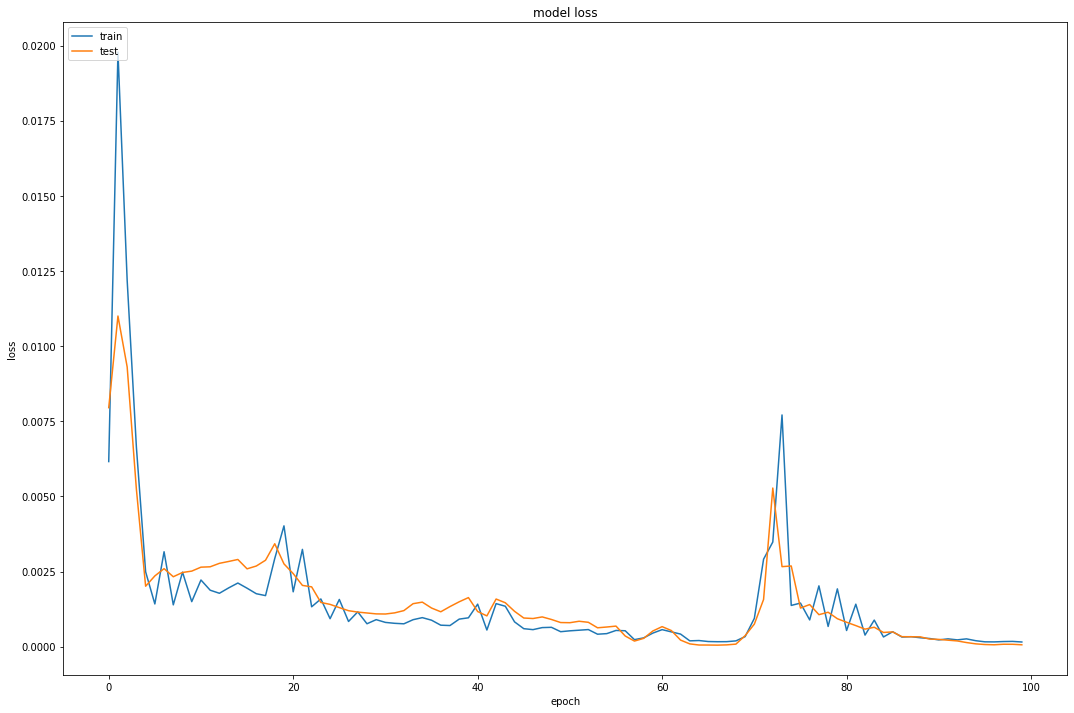

In [13]:
plt.figure(figsize = (18,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Prediction on Test Data

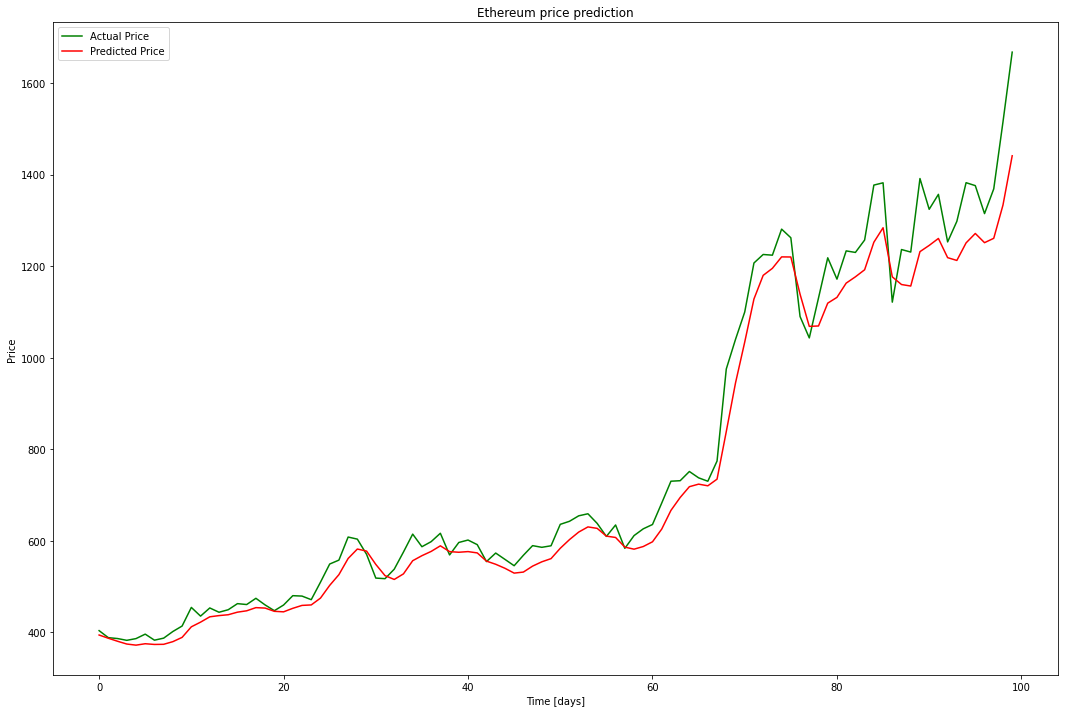

In [14]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.figure(figsize = (18,12))
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ethereum price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

Checking some real (*y_test_inverse*) and predicted *y_hat_inverse* values

In [15]:
y_test_inverse[85:]

array([[1382.27404785],
       [1121.57092285],
       [1236.51220703],
       [1230.99060059],
       [1391.609375  ],
       [1324.41479492],
       [1357.05810547],
       [1253.18713379],
       [1298.10180664],
       [1382.52282715],
       [1376.11547852],
       [1314.98620605],
       [1369.04052734],
       [1515.19372559],
       [1667.73999023]])

In [16]:
y_hat_inverse[85:]

array([[1284.1305],
       [1176.7771],
       [1160.0634],
       [1156.7576],
       [1231.906 ],
       [1245.5232],
       [1260.7169],
       [1218.7491],
       [1212.686 ],
       [1251.0323],
       [1271.6096],
       [1251.4996],
       [1261.0413],
       [1333.5847],
       [1441.3237]], dtype=float32)

In [17]:
df.tail(15)

,Date,Open,High,Low,Close,Adj Close,Volume
1989,2021-01-20,1375.248413,1405.744141,1243.299927,1382.274048,1382.274048,46784030909
1990,2021-01-21,1382.684448,1382.684448,1098.476196,1121.570923,1121.570923,45932464754
1991,2021-01-22,1118.889038,1271.687622,1046.596558,1236.512207,1236.512207,43918338506
1992,2021-01-23,1235.267944,1272.151123,1200.893311,1230.990601,1230.990601,27253895441
1993,2021-01-24,1231.210571,1395.111328,1225.274048,1391.609375,1391.609375,36418163554
1994,2021-01-25,1390.639893,1467.784912,1304.973999,1324.414795,1324.414795,43565777745
1995,2021-01-26,1323.741699,1376.085083,1253.340332,1357.058105,1357.058105,41572917750
1996,2021-01-27,1358.333374,1368.074097,1215.311279,1253.187134,1253.187134,39394416990
1997,2021-01-28,1251.279785,1321.613037,1226.173950,1298.101807,1298.101807,39790481941
1998,2021-01-29,1369.086792,1428.981201,1292.240112,1382.522827,1382.522827,53611955259


### Now, let's predict into the future.

Since 20 values are predicting the next one and there is no value for tomorrow to make prediction upon, I'm gonna make an artificial dummy values for that. I'm making a new sequence, where the last value will be repeated twice (inserting a dummy data) : if the last value for today is *[0.94239681]*, then this value will be set for tomorrow

Prediction array will be : pred_array
Target arrays will be:  targ_array

In [18]:
def get_prediction_array(X):
  """
  Inserts an other array to the end of the whole_data sequence in order to make
  array for predicting tomorrow's value

  returns: array of shape (None, 20, 1)
  """
  next = len(X)
  a = np.insert(X,[next],X[next-1], axis=0)
  for i_ in range(len(a[100]) - 1):
    if(i_ == 20):
      a[next][i_][0] == a[next][i_ - 1][0]
    else:
      a[next][i_][0] = a[next][i_ + 1][0]
  
  return a

In [19]:
pred_array = get_prediction_array(whole_data)
pred_array.shape

(1986, 20, 1)

In [20]:
pred_array[-2:], pred_array.shape

(array([[[0.70257071],
         [0.73957833],
         [0.73755989],
         [0.75381804],
         [0.82580028],
         [0.82878603],
         [0.67242405],
         [0.74136241],
         [0.73805072],
         [0.83438508],
         [0.79408377],
         [0.81366225],
         [0.75136354],
         [0.77830202],
         [0.82893524],
         [0.8250923 ],
         [0.78842878],
         [0.82084895],
         [0.90850729],
         [1.        ]],
 
        [[0.73957833],
         [0.73755989],
         [0.75381804],
         [0.82580028],
         [0.82878603],
         [0.67242405],
         [0.74136241],
         [0.73805072],
         [0.83438508],
         [0.79408377],
         [0.81366225],
         [0.75136354],
         [0.77830202],
         [0.82893524],
         [0.8250923 ],
         [0.78842878],
         [0.82084895],
         [0.90850729],
         [1.        ],
         [1.        ]]]), (1986, 20, 1))

In [21]:
targ_array = get_prediction_array(whole_targets)
targ_array.shape 

(1986, 1)

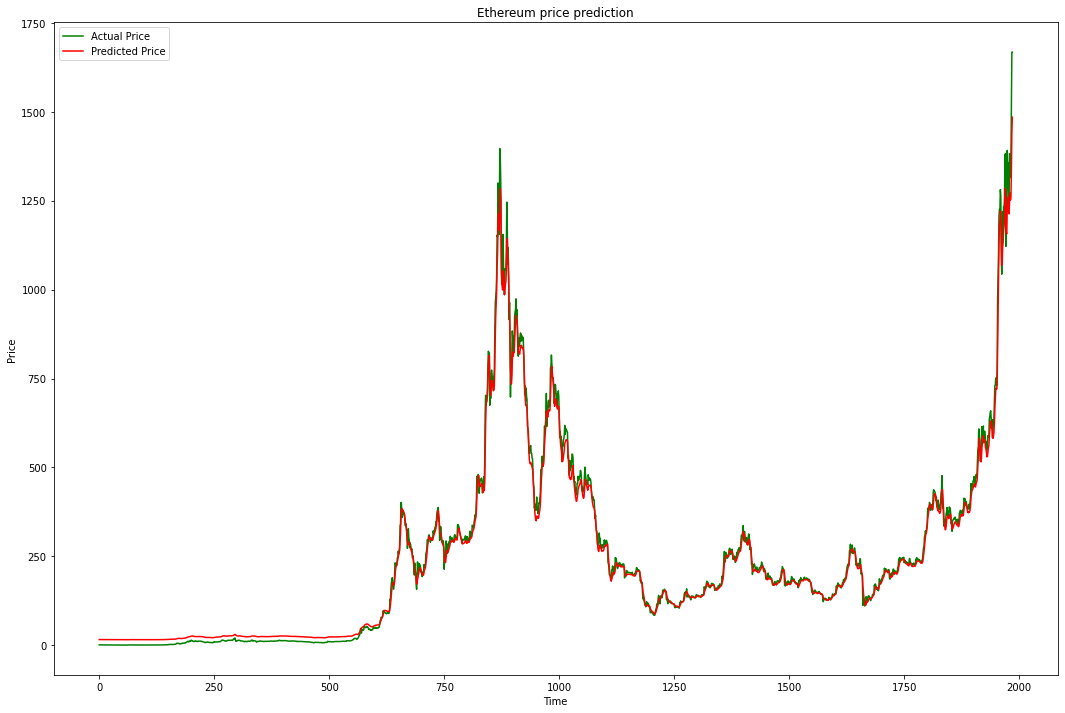

In [22]:
y_hat = model.predict(pred_array)

y_true_inverse = scaler.inverse_transform(targ_array)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.figure(figsize = (18,12))
plt.plot(y_true_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ethereum price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [23]:
print('Predicted Ethereum price for the next day: {} and predicted Ethereum price for the next day: {}'.format(y_hat_inverse[-1], y_true_inverse[-1]))

Predicted Ethereum price for the next day: [1485.0607] and predicted Ethereum price for the next day: [1667.73999023]


### Making a dataset of data-predicted-true values


**NOTE** - prediction starts from 20th **(SEQ_LEN)** day from *2015-08-07* 
This means, that the first *SEQ_LEN = 20* values do not have any prediction at all

In [24]:
# number of rows in DF
num_data_points = df.index.stop
# where the sequence prediction started from
started_ = num_data_points - len(y_true_inverse) + 1

In [25]:
tomorrow = date.today() + timedelta(days=1)
tomorrow = tomorrow.strftime('%Y-%m-%d')

ds = []

for i_ in df.Date[started_:]:
  ds.append(i_.strftime('%Y-%m-%d'))

ds.append(tomorrow)

print(len(ds), ds[-2:])

1986 ['2021-02-04', '2021-02-05']


### Last *true* value in **forecast** DataFrame is set to zero

In [33]:
y_true = y_true_inverse.reshape(len(y_true_inverse),)
y_true[-1] = 0
y_pred = y_hat_inverse.reshape(len(y_hat_inverse),)

d = {"ds": ds, "true": y_true, 'pred' : y_pred}
forecast = pd.DataFrame(d)
forecast

,ds,true,pred
0,2015-08-26,1.159980,16.154222
1,2015-08-27,1.147700,16.143066
2,2015-08-28,1.191380,16.120483
3,2015-08-29,1.182550,16.100328
4,2015-08-30,1.319270,16.111042
...,...,...,...
1981,2021-01-31,1314.986206,1251.499634
1982,2021-02-01,1369.040527,1261.041260
1983,2021-02-02,1515.193726,1333.584717
1984,2021-02-04,1667.739990,1441.323608


In [31]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100
...,...,...,...,...,...,...,...
1999,2021-01-30,1382.231934,1402.399780,1328.529053,1376.115479,1376.115479,30616574234
2000,2021-01-31,1376.823608,1378.916016,1288.501587,1314.986206,1314.986206,25198853581
2001,2021-02-01,1314.855225,1373.845825,1274.357788,1369.040527,1369.040527,29210670920
2002,2021-02-02,1369.505127,1542.990967,1362.771240,1515.193726,1515.193726,45437142801


### Saving the model


In [35]:
file_name = 'LSTM_ETH-1f.h5'
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `LSTM_ETH-1f.h5` to disk
